CV:    1.006
fano:  0.311


(0.0, 0.05)

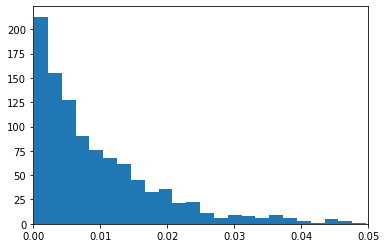

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

f = 100
T = 10
k = 100 #for defining how much space should be between two poisson spikes, per second there are f*k timesteps
dt = 1/(f*k) # take time steps k times smaller than histogram
t = np.linspace(0,T,round(T/dt))
spikes = np.zeros(round(T/dt),dtype=int)

for i in range(len(spikes)):
    spikes[i] = np.random.poisson(1/k) # np.sum(spikes)=T*f should be in the end 
ISI = np.diff(np.where(spikes==1))[0]*dt
CV = np.std(ISI)/np.mean(ISI)
spikes_reshaped = np.sum(spikes.reshape(round(0.1/dt),round(len(spikes)/round(0.1/dt))),0)
fano = np.std(spikes_reshaped)/np.mean(spikes_reshaped)
print("CV:   ",round(CV,3))
print("fano: ",round(fano,3))


plt.hist(ISI,bins=30)
plt.xlim(0,0.05)


In [224]:
ISI

array([0.0063, 0.0009, 0.0236, 0.015 , 0.0068, 0.0013, 0.0001, 0.0292,
       0.0001, 0.0021, 0.0157, 0.0188, 0.0005, 0.0174, 0.0126, 0.0091,
       0.0059, 0.0072, 0.0009, 0.0018, 0.0009, 0.0185, 0.0007, 0.0061,
       0.025 , 0.0141, 0.0016, 0.0018, 0.0087, 0.0155, 0.0123, 0.0017,
       0.0267, 0.0138, 0.0225, 0.0126, 0.0077, 0.0004, 0.0061, 0.0132,
       0.016 , 0.0056, 0.0042, 0.0027, 0.0184, 0.0037, 0.0007, 0.007 ,
       0.0158, 0.0002, 0.015 , 0.0003, 0.0033, 0.0017, 0.0303, 0.0064,
       0.0076, 0.0236, 0.0029, 0.0181, 0.0002, 0.0153, 0.0044, 0.0113,
       0.0028, 0.0033, 0.0124, 0.0037, 0.0208, 0.006 , 0.0056, 0.0281,
       0.0131, 0.0016, 0.0023, 0.0178, 0.0472, 0.0111, 0.0075, 0.0127,
       0.0036, 0.0049, 0.0196, 0.0102, 0.0049, 0.0287, 0.0021, 0.036 ,
       0.0182, 0.004 , 0.0052, 0.0102, 0.0011, 0.0037, 0.0035, 0.0057,
       0.0078, 0.003 , 0.0058, 0.0107, 0.0105, 0.0032, 0.0348, 0.0012,
       0.0057, 0.0129, 0.0197, 0.0032, 0.0052, 0.0072, 0.0042, 0.008 ,
      